# IE 582 - HW2 - 5 Datasets Analysis

Prepared by Abdullah Kayacan

## Datasets

- All criteria needed for the dataset are met
  - Each dataset has pre-defined training and test sets 

### 1. IDA2016

- **Source**: https://archive.ics.uci.edu/dataset/414/ida2016challenge
- **Objective**: Finding whether Air Pressure System (APS) that generates sufficient air pressure for a truck to function correctly fails or not in the given cases.
- **Number of attributes**: 171 (Continuous: 164, Ordinal: 7)
- **Problem Type**: Binary classification
- Anonymized features.

####
- **Criteria met**:
  - p>>100
  - Imbalanced data (train positive rate: 0.0167, test positive rate: 0.0234)
  - Non-continuous features
- We handled missing data by simply taking the average for each column in the training set. The same is valid for the ordinal values.

### 2. HillValey

- **Source**: https://archive.ics.uci.edu/dataset/166/hill+valley
- **Objective**: Predictiong whether a given instance is hill or valley by evaluating the y coordinate of the sequenced points.
- **Number of attributes**: 100 (Continuous: 100) 
- The features are the y coordinate for the given sequence. We preferred noisy data in the assignment.
- Here are examples for noisy ve smoothed data

![Hill Valley Example Data](Hill_Valley_visual_examples.jpg "Hill Valley Example Data")


### 3. Smartphone

- **Source**: https://archive.ics.uci.edu/dataset/364/smartphone+dataset+for+human+activity+recognition+har+in+ambient+assisted+living+aal
- **Objective**: Activity recognition by using spatial features acquired by the phones of the users.
- **Number of attributes**: 561 (Continuous: 561) 
- The features are the some descriptive statistics (mean, std, min, max ,iqr, entropy, corr, etc.) of the collected velocity and acceleration data.
- **Classes**:
  - **0**: *WALKING*
  - **1**: *WALKING_UPSTAIRS*
  - **2**: *WALKING_DOWNSTAIRS*
  - **3**: *SITTING*
  - **4**: *STANDING*
  - **5**: *LAYING*

####
- **Criteria met**:
  - p>>100
  - Multi-class

### 4. YearPrediction

- **Source**: https://archive.ics.uci.edu/dataset/203/yearpredictionmsd
- **Objective**: Prediction of the year of a given song by its musical attributes
- **Number of attributes**: 90 (Continuous: 90) 
- The feautres are average (12 of them) andcovariance (78) of timbre in song.

####
- **Criteria met**:
  - Regression

### 5. Reuters

- **Source**: https://archive.ics.uci.edu/dataset/217/reuter+50+50
- **Objective**: Prediction of the author of a given article content.
- **Number of attributes**: 100 (Categorical/Binary: 100)
- In the trainin set, words in all texts are extracted after some preprocessing. Then, stop-words are removed. 100 most used words are taken as variable in our models (1 if word is in the text, 0 otherwise).
- **Classes**: 50 authors. Number of texts are evenly divided.

####
- **Criteria met**:
  - Multi-Class
  - Non-continuous features

## Module Imports

In [1]:
import os
import pickle
import joblib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from lightgbm import LGBMClassifier,LGBMRegressor

from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support,mean_squared_error,mean_absolute_error

import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\usera\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Functions Used

### To get data smoothly:

In [2]:
def get_data(data_source):
    if data_source == "IDA2016":
        train = pd.read_csv("IDA2016Challenge/aps_failure_training_set.csv",skiprows=20)
        test = pd.read_csv("IDA2016Challenge/aps_failure_test_set.csv",skiprows=20)
    elif data_source == "HillValley":
        train = pd.read_csv("HillValley/Hill_Valley_with_noise_Training.data")
        test = pd.read_csv("HillValley/Hill_Valley_with_noise_Testing.data")
        train = pd.concat([train.iloc[:,-1],train.iloc[:,:-1]],axis=1)
        test = pd.concat([test.iloc[:,-1],test.iloc[:,:-1]],axis=1)
    elif data_source == "Smartphone":
        train_X = pd.read_csv("Smartphone/final_X_train.txt",header=None)
        train_y = pd.read_csv("Smartphone/final_y_train.txt",header=None)-1
        train = pd.concat([train_y,train_X],axis=1).T.reset_index(drop=True).T
        train.iloc[:,0] = train.iloc[:,0].astype(int)
        test_X = pd.read_csv("Smartphone/final_X_test.txt",header=None)
        test_y = pd.read_csv("Smartphone/final_y_test.txt",header=None)-1
        test = pd.concat([test_y,test_X],axis=1).T.reset_index(drop=True).T
        test.iloc[:,0] = train.iloc[:,0].astype(int)
        del train_X,train_y,test_X,test_y
    elif data_source == "YearPrediction":
        """
        Data source indicates that:
        * You should respect the following train / test split:
        * train: first 463,715 examples
        * test: last 51,630 examples
        """
        data = pd.read_csv("YearPrediction/YearPredictionMSD.txt",header=None)
        n_train = 463715
        train,test = data.iloc[:n_train],data.iloc[n_train:]
    else:
        authors = os.listdir("Reuters/C50train")
        train = []
        test = []
        for author in authors:
            train_files = [f'Reuters/C50train/{author}/{e}' for e in os.listdir(f'Reuters/C50train/{author}')]
            for train_file in train_files:
                with open(train_file, 'r') as file:
                    content = file.read()
                train.append([author,content])

            
            test_files = [f'Reuters/C50test/{author}/{e}' for e in os.listdir(f'Reuters/C50test/{author}')]
            for test_file in test_files:
                with open(test_file, 'r') as file:
                    content = file.read()
                test.append([author,content])
        train = pd.DataFrame(train)
        test = pd.DataFrame(test)

    return train,test


### Dictionary flattening
This function is taken from https://stackoverflow.com/questions/13575090/construct-pandas-dataframe-from-items-in-nested-dictionary

In [3]:
### This function is taken from https://stackoverflow.com/questions/13575090/construct-pandas-dataframe-from-items-in-nested-dictionary
def flatten_dict(nested_dict,exceptions = []):
    res = {}
    if isinstance(nested_dict, dict):
        for k in nested_dict:
            flattened_dict = flatten_dict(nested_dict[k])
            for key, val in flattened_dict.items():
                if key not in exceptions:
                    key = list(key)
                    key.insert(0, k)
                    res[tuple(key)] = val
    else:
        res[()] = nested_dict
    return res


### Dictionary-to-List function

In [4]:

def dict_to_list(d):
    res = []
    for k,v in d.items():
        k = list(k)
        k.append(v)
        res.append(k)
    return res

## Data Retrieval & Preprocessing

IDA2016


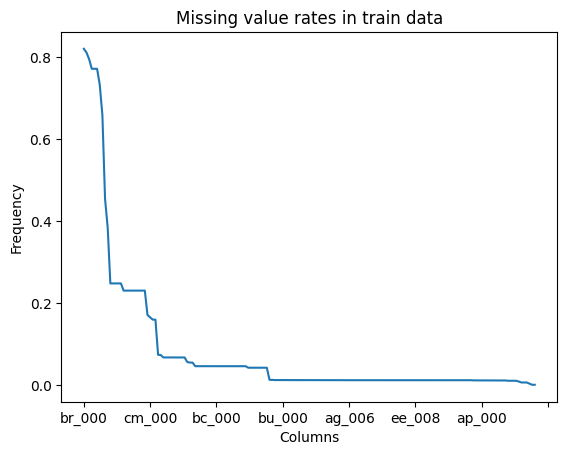

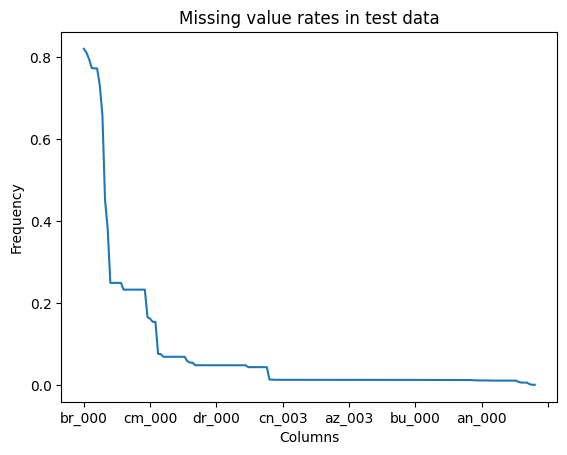

---
HillValley
---
Smartphone
---
YearPrediction
---
Reuters


In [5]:
data_for_models = {}

train,test = get_data(data_source="IDA2016")
train = train.replace("na",np.nan)
test = test.replace("na",np.nan)

print("IDA2016")

train.isna().mean().sort_values(ascending=False).plot(title="Missing value rates in train data",xlabel="Columns",ylabel="Frequency")
plt.show()
test.isna().mean().sort_values(ascending=False).plot(title="Missing value rates in test data",xlabel="Columns",ylabel="Frequency")
plt.show()
print("---")

featıres = train.columns[1:]
target_col = train.columns[0]
train[featıres] = train[featıres].astype(float)
filler = train[featıres].mean()
train[featıres] = train[featıres].fillna(filler)
test[featıres] = test[featıres].fillna(filler)
train[target_col] = train[target_col].map({"neg":0,"pos":1})
test[target_col] = test[target_col].map({"neg":0,"pos":1})
train[target_col] = train[target_col].astype(int)
test[target_col] = test[target_col].astype(int)


data_for_models["IDA2016"] = {"train": train.copy(), "test":test.copy()}

train,test = get_data(data_source="HillValley")
data_for_models["HillValley"] = {"train": train.copy(), "test":test.copy()}

print("HillValley")
print("---")

train,test = get_data(data_source="Smartphone")
data_for_models["Smartphone"] = {"train": train.copy(), "test":test.copy()}

print("Smartphone")
print("---")

train,test = get_data(data_source="YearPrediction")
data_for_models["YearPrediction"] = {"train": train.copy(), "test":test.copy()}

print("YearPrediction")
print("---")

train,test = get_data(data_source="Reuters")
train[1] = [re.sub('[^A-Za-z0-9]+', ' ', e.lower()).replace("  "," ") for e in train[1]]
train[1] = [re.sub('\d+', ' ', e).replace("  "," ").split(" ") for e in train[1]]
test[1] = [re.sub('[^A-Za-z0-9]+', ' ', e.lower()).replace("  "," ") for e in test[1]]
test[1] = [re.sub('\d+', ' ', e).replace("  "," ").split(" ") for e in test[1]]

train_all_words = np.array([item for sublist in train[1].values for item in sublist])
train_all_words = train_all_words[~np.isin(train_all_words,stopwords.words('english'))]
word_counts = pd.DataFrame(np.unique(train_all_words,return_counts=True)).T
word_counts.sort_values(1,ascending=False).iloc[:100,0]
features = word_counts.sort_values(1,ascending=False).iloc[:100,0].values

train = pd.concat([train.iloc[:,:1],pd.DataFrame([np.isin(features,e) for e in train[1].values])],axis=1).T.reset_index(drop=True).T
test = pd.concat([test.iloc[:,:1],pd.DataFrame([np.isin(features,e) for e in test[1].values])],axis=1).T.reset_index(drop=True).T

authors = sorted(list(set(train.iloc[:,0])))
authors_to_num = {a:i for i,a in enumerate(authors)}
train = train.replace(authors_to_num)
test = test.replace(authors_to_num)

data_for_models["Reuters"] = {"train": train.copy(), "test":test.copy()}

print("Reuters")

for data_name in data_for_models.keys():
    np.random.seed(1)
    data_for_models[data_name]["skf"] = StratifiedKFold(n_splits=5)
    data_for_models[data_name]["skf"].get_n_splits(data_for_models[data_name]["train"].iloc[:,1:], data_for_models[data_name]["train"].iloc[:,0])

    data_for_models[data_name]["binary_classification"] = True if len(set(data_for_models[data_name]["train"].iloc[:,0])) == 2 else False
    data_for_models[data_name]["classification"] = False if data_name == "YearPrediction" else True

## Descriptive Statistics of Datasets

#### IDA2016

In [6]:
data_name = "IDA2016"

**Descriptive Statistics**:

In [7]:
data_for_models[data_name]["train"].describe()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,6.000000e+04,60000.000000,6.000000e+04,6.000000e+04,60000.000000,60000.000000,6.000000e+04,6.000000e+04,6.000000e+04,...,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,60000.000000,60000.000000
mean,0.016667,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,...,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,0.128020,1.454301e+05,1.660588,7.724678e+08,3.504515e+07,158.142022,205.375337,2.036363e+04,3.400875e+04,1.494791e+05,...,1.149060e+06,5.402722e+05,1.161763e+06,1.114758e+06,1.063164e+06,1.718366e+06,4.469894e+05,4.720424e+04,4.268529,8.627929
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.000000,8.340000e+02,0.713189,2.000000e+01,4.200000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,3.033500e+03,1.204000e+03,2.848500e+03,3.839000e+03,5.600000e+02,1.180000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,0.000000,3.077600e+04,0.713189,1.880000e+02,2.880000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,2.397270e+05,1.148530e+05,2.283220e+05,1.960600e+05,9.976600e+04,4.358700e+04,4.474000e+03,0.000000e+00,0.000000,0.000000
75%,0.000000,4.866800e+04,0.713189,1.686000e+03,8.426500e+03,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,4.454897e+05,2.164440e+05,4.624655e+05,4.003010e+05,2.833455e+05,1.732245e+05,1.387300e+05,2.366000e+03,0.000000,0.000000
max,1.000000,2.746564e+06,204.000000,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,3.160781e+07,1.195801e+08,1.926740e+07,3.810078e+06,482.000000,1146.000000


**Correlation Heatmap**:

<Axes: >

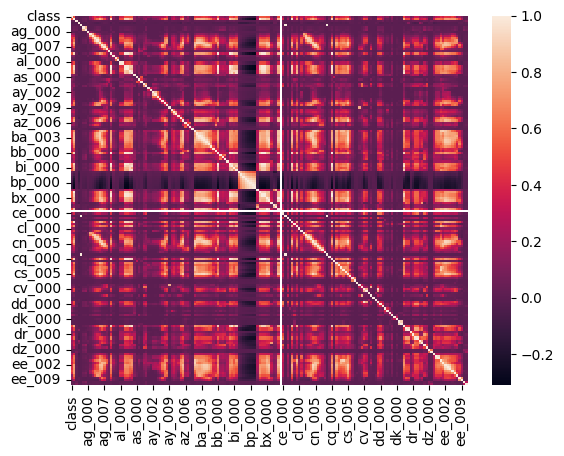

In [8]:
sns.heatmap(data_for_models[data_name]["train"].corr())

#### HillValley

In [9]:
data_name = "HillValley"

**Descriptive Statistics**:

In [10]:
data_for_models[data_name]["train"].describe()

,class,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100
count,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.00000,...,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000
mean,0.493399,7992.946271,7954.453564,7975.187822,8002.847442,7954.192904,7944.225429,7993.374307,7991.241518,7943.23429,...,7883.636733,7947.760248,7974.565413,7962.931502,7921.486320,8038.357508,8016.717030,7931.057772,7986.870149,7972.507954
std,0.500369,18023.852201,17865.546766,18012.257018,17961.897465,17894.525964,17779.349130,17956.058741,18096.353648,17919.18086,...,17445.762729,17743.807876,17874.682849,17776.297537,17677.409855,18082.357385,17952.438298,17710.380270,18002.231542,17841.974654
min,0.000000,0.930000,0.900000,0.850000,0.890000,0.880000,0.860000,0.870000,0.650000,0.65000,...,0.950000,0.940000,0.900000,0.870000,0.900000,0.890000,0.890000,0.970000,0.940000,0.890000
25%,0.000000,17.970000,16.022500,17.440000,16.210000,16.775000,16.095000,16.745000,17.222500,17.07750,...,16.745000,17.127500,16.775000,16.570000,16.565000,16.737500,17.912500,16.750000,17.252500,16.380000
50%,0.000000,265.170000,264.480000,266.230000,271.185000,270.385000,259.550000,267.605000,257.475000,260.98000,...,266.250000,269.200000,268.020000,259.350000,271.605000,278.140000,280.070000,277.600000,269.640000,262.690000
75%,1.000000,4942.142500,5013.467500,5098.742500,4950.452500,4992.727500,5049.345000,4954.785000,5034.550000,5066.67500,...,5042.445000,4962.887500,4914.665000,5053.047500,4834.680000,4997.377500,4934.832500,4959.362500,4826.522500,4995.110000
max,1.000000,117807.870000,108453.740000,119031.350000,109631.560000,113000.470000,116848.390000,115609.240000,115592.180000,112895.90000,...,101072.900000,110666.700000,111632.910000,109710.300000,112933.730000,111413.860000,115110.420000,116431.960000,113291.960000,112348.130000


**Correlation Heatmap**:

<Axes: >

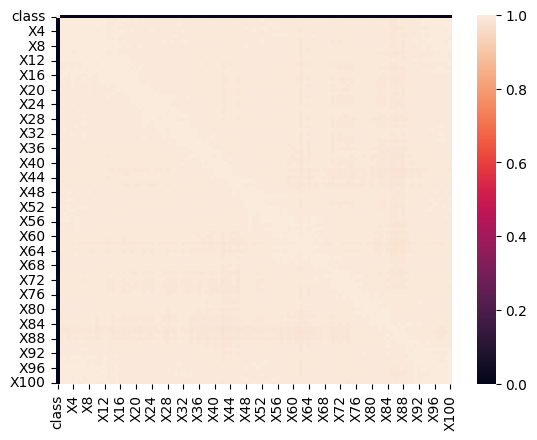

In [11]:
sns.heatmap(data_for_models[data_name]["train"].corr())

#### Smartphone

In [12]:
data_name = "Smartphone"

**Class Counts**:

In [13]:
data_for_models[data_name]["train"].iloc[:,0].value_counts()

0
3.0    834
4.0    775
0.0    769
2.0    691
1.0    629
5.0    554
Name: count, dtype: int64

**Descriptive Statistics**:

In [14]:
data_for_models[data_name]["train"].describe()

,0,1,2,3,4,5,6,7,8,9,...,552,553,554,555,556,557,558,559,560,561
count,4252.000000,4252.000000,4252.000000,4252.000000,4252.000000,4252.000000,4252.000000,4252.000000,4252.000000,4252.000000,...,4252.000000,4252.000000,4252.000000,4252.000000,4252.000000,4252.000000,4252.000000,4252.000000,4252.000000,4252.000000
mean,2.441910,0.328098,-0.016892,-0.105908,-0.657875,-0.545393,-0.568119,-0.692565,-0.555668,-0.567608,...,0.132243,-0.289747,-0.618739,-0.026148,0.032900,0.002336,-0.003853,-0.525921,0.070942,-0.022324
std,1.665701,0.342924,0.064407,0.116318,0.357233,0.428247,0.409752,0.331081,0.422234,0.415663,...,0.235170,0.294440,0.285924,0.327898,0.445712,0.595877,0.514740,0.434306,0.244521,0.310260
min,0.000000,-2.558400,-0.885720,-1.006100,-1.000100,-0.999270,-1.005300,-1.000000,-0.999280,-1.005400,...,-0.793830,-0.955590,-1.006300,-1.001000,-0.992450,-0.995690,-0.987830,-0.997540,-0.795520,-1.093500
25%,1.000000,0.260400,-0.027013,-0.129390,-0.985930,-0.963715,-0.966993,-0.987775,-0.964815,-0.966835,...,-0.007369,-0.500945,-0.826233,-0.120405,-0.240812,-0.554740,-0.450703,-0.800307,-0.062248,-0.135370
50%,3.000000,0.277880,-0.017045,-0.108480,-0.711575,-0.555900,-0.566125,-0.753750,-0.568120,-0.563235,...,0.148570,-0.323800,-0.695040,0.006337,0.027131,0.004438,-0.005088,-0.676585,0.061055,0.040008
75%,4.000000,0.300503,-0.006720,-0.090234,-0.413538,-0.187390,-0.235938,-0.484675,-0.207490,-0.241415,...,0.292135,-0.115175,-0.494525,0.101587,0.317148,0.551520,0.437635,-0.496592,0.192235,0.185645
max,5.000000,2.409900,0.769080,1.658900,0.947430,1.594100,2.041200,1.024800,1.864200,2.464300,...,0.864680,0.942590,0.933850,0.995080,1.011000,0.996520,0.993710,0.937120,0.825490,0.629590


**Correlation Heatmap**:

<Axes: >

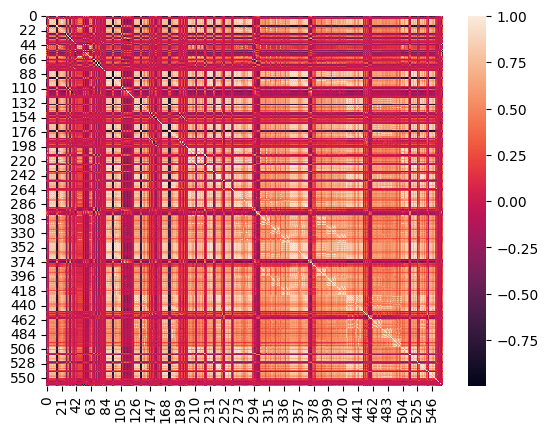

In [15]:
sns.heatmap(data_for_models[data_name]["train"].corr())

#### YearPrediction

In [16]:
data_name = "YearPrediction"

**Output Distribution**:

Text(0.5, 1.0, 'Output: Release year of the songs')

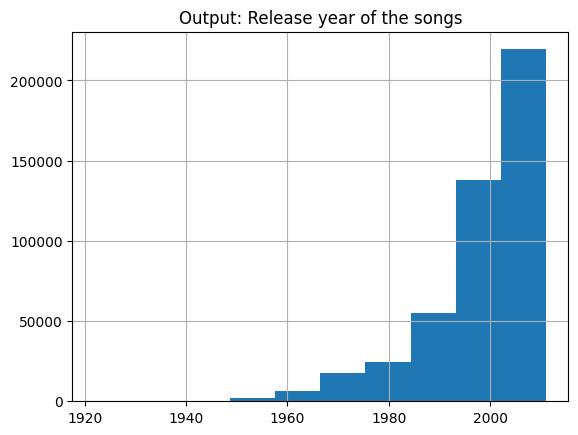

In [17]:
data_for_models[data_name]["train"].iloc[:,0].hist()
plt.title("Output: Release year of the songs")

**Descriptive Statistics**:

In [18]:
data_for_models[data_name]["train"].describe()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
count,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,...,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000
mean,1998.386095,43.385488,1.261091,8.650195,1.130763,-6.512725,-9.565527,-2.384609,-1.793722,3.714584,...,15.743361,-73.067753,41.423976,37.780868,0.345259,17.599280,-26.364826,4.444985,19.739307,1.323326
std,10.939767,6.079139,51.613473,35.264750,16.334672,22.855820,12.836758,14.580245,7.961876,10.579241,...,32.086356,175.376872,121.794610,94.874474,16.153797,114.336522,174.187892,13.320996,184.843503,22.045404
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-318.223330
25%,1994.000000,39.957540,-26.153810,-11.441920,-8.515155,-20.636960,-18.468705,-10.776340,-6.461400,-2.303600,...,-1.798085,-139.062035,-20.918635,-4.711470,-6.758160,-31.563615,-101.396245,-2.572830,-59.598030,-8.813335
50%,2002.000000,44.262570,8.371550,10.470520,-0.691610,-5.992740,-11.208850,-2.047850,-1.735440,3.816840,...,9.161360,-52.878010,28.709870,33.494550,0.828350,15.554490,-21.123570,3.111120,7.586950,0.052840
75%,2006.000000,47.833650,36.143780,29.741165,8.756995,7.749590,-2.422590,6.515710,2.905130,9.950960,...,26.248290,13.620660,89.419995,77.674700,8.495715,67.743725,52.299850,9.948955,86.203115,9.670740
max,2011.000000,61.970140,384.065730,322.851430,289.527430,262.068870,119.815590,172.402680,105.210280,146.297950,...,840.973380,4469.454870,3210.701700,1672.647100,260.544900,3662.065650,2833.608950,463.419500,7393.398440,600.766240


**Correlation Heatmap**:

<Axes: >

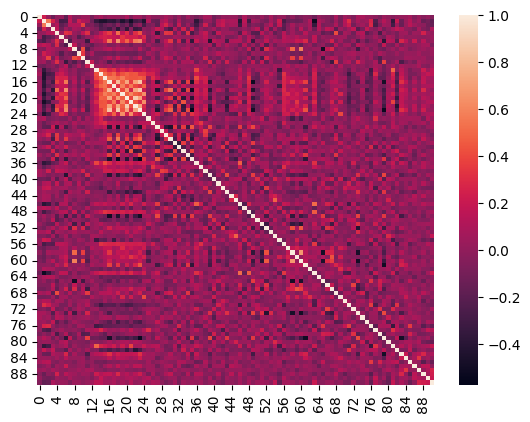

In [19]:
sns.heatmap(data_for_models[data_name]["train"].corr())

#### Reuters

In [20]:
data_name = "Reuters"

**Class Counts**:

In [21]:
pd.DataFrame(data_for_models[data_name]["train"].iloc[:,0].value_counts()).sort_index().T

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50


**Descriptive Statistics**:

In [22]:
data_for_models[data_name]["train"].astype(int).describe()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
count,2500.000000,2500.0,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,...,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,24.500000,1.0,0.992800,0.722000,0.604800,0.727600,0.546000,0.519200,0.590400,0.516000,...,0.236400,0.193600,0.252000,0.275600,0.171200,0.238000,0.184800,0.228000,0.156400,0.266400
std,14.433757,0.0,0.084564,0.448103,0.488991,0.445284,0.497979,0.499731,0.491858,0.499844,...,0.424956,0.395198,0.434248,0.446906,0.376759,0.425944,0.388213,0.419627,0.363307,0.442164
min,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24.500000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,49.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Correlation Heatmap**:

<Axes: >

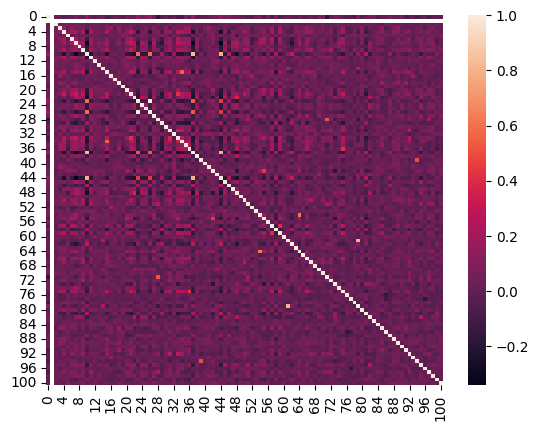

In [23]:
sns.heatmap(data_for_models[data_name]["train"].astype(int).corr())

### Cross-Validation Runs

- 5-Fold CV was applied.
- Algorithms and tuned parameters:
    - **KNN** (*knn*):
      - **distance measure** (*p*): takes 1 for L1, 2 for L2 norm
      - **number of neigbors** (*k*): 1 to 5
    - **Decision Trees** (*dt*)
      - **minimal number of observations per tree leaf** (*min_samples_leaf*): 1 to 5 since it is suggested in this range.
      - **minimum number of observations to split**: twice of *min_samples_leaf*
    - **Random Forest** (*rf*)
      - **number of features** (*m*): takes *1*, *sqrt(p)/2*, *sqrt(p)*, and *sqrt(p)*2*
    - **LightGBM** (*gbm*)
      - **max depth** (*md*): takes 1,3,7, and -1 (no limit)
      - **number of trees** (*nt*): takes 100, 250, and 500
      - **learning rate** (*lr*): takes 0.05, 0.1, and 0.2
- Calculated performance metrics
  - For binary classification problems: confusion matrix, roc-auc, precision, recall, f-score
  - For mult-class classification problems: confusion matrix, precision, recall, f-score
  - For regression problem: mean squared error, mean absolute error

In [24]:
cv_results = {d:{m:{} for m in ["knn","dt","rf","gbm"]} for d in data_for_models.keys()}
cv_results = joblib.load("cv_results.pkl")
joblib.dump(cv_results,"cv_results.pkl")
it = 0
for data_name in data_for_models.keys():
    skf = data_for_models[data_name]["skf"]
    train = data_for_models[data_name]["train"]
    test = data_for_models[data_name]["test"]

    for i, (train_index, test_index) in enumerate(skf.split(train.iloc[:,1:], train.iloc[:,0])):
        # train_index = train_index[:100]
        # test_index = test_index[:100]
        y_train,X_train = train.iloc[train_index,0],train.iloc[train_index,1:]
        y_valid,X_valid = train.iloc[test_index,0],train.iloc[test_index,1:]

        model_name = "knn"
        distance_metrics = [1,2]  # Minkowski metric parameter, 1 for manhattan, 2 for euclidean
        n_neighbors = [1,2,3,4,5]  # Number of neighbours
        

        cv_results[data_name][model_name][i] = {}
        for p in distance_metrics:
            cv_results[data_name][model_name][i][p] = {}
            for k in n_neighbors:
                cv_results[data_name][model_name][i][p][k] = {}

                model_function = KNeighborsClassifier if data_for_models[data_name]["classification"] else KNeighborsRegressor
                model = model_function(n_jobs=-1,n_neighbors=k,p=p)
                model.fit(X_train, y_train)

                if data_for_models[data_name]["classification"]:
                    pred_proba = model.predict_proba(X_valid)
                    pred = pred_proba.argmax(1)
                    cv_results[data_name][model_name][i][p][k]["cm"] = confusion_matrix(y_valid, pred)
                    if data_for_models[data_name]["binary_classification"]:
                        cv_results[data_name][model_name][i][p][k]["ra"] = roc_auc_score(y_valid, pred_proba[:,1])
                    cv_results[data_name][model_name][i][p][k]["prfs"] = precision_recall_fscore_support(y_valid, pred)
                    it += 1
                else:
                    pred = model.predict(X_valid)
                    cv_results[data_name][model_name][i][p][k]["mse"] = mean_squared_error(y_valid, pred)
                    cv_results[data_name][model_name][i][p][k]["mae"] = mean_absolute_error(y_valid, pred)
                # break
            # break
        joblib.dump(cv_results,"cv_results.pkl")

        model_name = "dt"
        min_samples_leaf = [1,2,3,4,5]

        cv_results[data_name][model_name][i] = {}
        for m in min_samples_leaf:
            cv_results[data_name][model_name][i][m] = {}
            model_function = DecisionTreeClassifier if data_for_models[data_name]["classification"] else DecisionTreeRegressor
            model = model_function(random_state=0,ccp_alpha=0,min_samples_leaf=m,min_samples_split=m*2)
            model.fit(X_train, y_train)

            if data_for_models[data_name]["classification"]:
                pred_proba = model.predict_proba(X_valid)
                pred = pred_proba.argmax(1)
                cv_results[data_name][model_name][i][m]["cm"] = confusion_matrix(y_valid, pred)
                if data_for_models[data_name]["binary_classification"]:
                    cv_results[data_name][model_name][i][m]["ra"] = roc_auc_score(y_valid, pred_proba[:,1])
                cv_results[data_name][model_name][i][m]["prfs"] = precision_recall_fscore_support(y_valid, pred)
            else:
                pred = model.predict(X_valid)
                cv_results[data_name][model_name][i][m]["mse"] = mean_squared_error(y_valid, pred)
                cv_results[data_name][model_name][i][m]["mae"] = mean_absolute_error(y_valid, pred)
            it += 1
            # break
        joblib.dump(cv_results,"cv_results.pkl")

        model_name = "rf"
        n_features = train.shape[1]-1
        max_features = ["1","sqrt/2","sqrt","sqrt*2"]
        max_feature_values = [1,np.rint(np.sqrt(n_features)/2).astype(int),np.rint(np.sqrt(n_features)).astype(int),np.rint(np.sqrt(n_features)*2).astype(int)]
        max_features_map = {max_features[m]:max_feature_values[m] for m in range(len(max_features))}

        cv_results[data_name][model_name][i] = {}
        for m in max_features:
            cv_results[data_name][model_name][i][m] = {}
            model_function = RandomForestClassifier if data_for_models[data_name]["classification"] else RandomForestRegressor
            model = model_function(random_state=0,n_jobs=3,max_features=max_features_map[m])
            model.fit(X_train, y_train)

            if data_for_models[data_name]["classification"]:
                pred_proba = model.predict_proba(X_valid)
                pred = pred_proba.argmax(1)
                cv_results[data_name][model_name][i][m]["cm"] = confusion_matrix(y_valid, pred)
                if data_for_models[data_name]["binary_classification"]:
                    cv_results[data_name][model_name][i][m]["ra"] = roc_auc_score(y_valid, pred_proba[:,1])
                cv_results[data_name][model_name][i][m]["prfs"] = precision_recall_fscore_support(y_valid, pred)
            else:
                pred = model.predict(X_valid)
                cv_results[data_name][model_name][i][m]["mse"] = mean_squared_error(y_valid, pred)
                cv_results[data_name][model_name][i][m]["mae"] = mean_absolute_error(y_valid, pred)
            it += 1
            # break
        joblib.dump(cv_results,"cv_results.pkl")

        model_name = "gbm"
        n_features = train.shape[1]-1
        max_depths = [1,3,7,-1]
        n_trees = [100,250,500]
        learning_rates = [.05,.1,.2]

        cv_results[data_name][model_name][i] = {}
        for md in max_depths:
            cv_results[data_name][model_name][i][md] = {}
            for nt in n_trees:
                cv_results[data_name][model_name][i][md][nt] = {}
                for lr in learning_rates:
                    cv_results[data_name][model_name][i][md][nt][lr] = {}
                    model_function = LGBMClassifier if data_for_models[data_name]["classification"] else LGBMRegressor
                    model = model_function(random_state=0,n_jobs=-1,verbose=-1,max_depth=md,n_estimators=nt,learning_rate=lr)
                    model.fit(X_train, y_train)

                    if data_for_models[data_name]["classification"]:
                        pred_proba = model.predict_proba(X_valid)
                        pred = pred_proba.argmax(1)
                        cv_results[data_name][model_name][i][md][nt][lr]["cm"] = confusion_matrix(y_valid, pred)
                        if data_for_models[data_name]["binary_classification"]:
                            cv_results[data_name][model_name][i][md][nt][lr]["ra"] = roc_auc_score(y_valid, pred_proba[:,1])
                        cv_results[data_name][model_name][i][md][nt][lr]["prfs"] = precision_recall_fscore_support(y_valid, pred)
                    else:
                        pred = model.predict(X_valid)
                        cv_results[data_name][model_name][i][md][nt][lr]["mse"] = mean_squared_error(y_valid, pred)
                        cv_results[data_name][model_name][i][md][nt][lr]["mae"] = mean_absolute_error(y_valid, pred)
                        it += 1
                    # break
            #     break
            # break
        joblib.dump(cv_results,"cv_results.pkl")



### CV Evaluation

- Average of 5-folds for each algorithm in each dataset is used to compare
- Metrics used to decide test parameter selection:
  - ROC-AUC is used for **IDA2016** dataset due to the class imbalance problem.
  - Accuracy metric is calculated for the remaining classification problems.
  - For the regression problem, mean squared error is preferred since it is more responsive for the high individual errors.
- The code below outputs the top three algorithm parameters for the algorithms and datasets. The parameters in the first row of each table is used in test models.

In [25]:
cv_model_results_to_compare = {data_name:[] for data_name in data_for_models.keys()}
data_name = "IDA2016"
print(data_name)
# df_model_perfs
print("knn")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["knn"])))
df_model = df_model[df_model.iloc[:,3] == "ra"].groupby([1,2])[4].mean().reset_index().sort_values(4,ascending=False)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("dt")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["dt"])))
df_model = df_model[df_model.iloc[:,2] == "ra"].groupby([1])[3].mean().reset_index().sort_values(3,ascending=False)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("rf")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["rf"])))
df_model = df_model[df_model.iloc[:,2] == "ra"].groupby([1])[3].mean().reset_index().sort_values(3,ascending=False)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("gbm")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["gbm"])))
df_model = df_model[df_model.iloc[:,4] == "ra"].groupby([1,2,3])[5].mean().reset_index().sort_values(5,ascending=False)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("----------------------------------")
print("----------------------------------")

data_name = "HillValley"
print(data_name)

print("knn")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["knn"])))
df_model = df_model[df_model.iloc[:,3] == "cm"]
df_model[4] = [e.diagonal().sum()/e.sum() for e in df_model[4]]
df_model = df_model.groupby([1,2])[4].mean().reset_index().sort_values(4,ascending=False)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("dt")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["dt"])))
df_model = df_model[df_model.iloc[:,2] == "cm"]
df_model[3] = [e.diagonal().sum()/e.sum() for e in df_model[3]]
df_model = df_model.groupby([1])[3].mean().reset_index().sort_values(3,ascending=False)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("rf")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["rf"])))
df_model = df_model[df_model.iloc[:,2] == "cm"]
df_model[3] = [e.diagonal().sum()/e.sum() for e in df_model[3]]
df_model = df_model.groupby([1])[3].mean().reset_index().sort_values(3,ascending=False)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("gbm")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["gbm"])))
df_model = df_model[df_model.iloc[:,4] == "cm"]
df_model[5] = [e.diagonal().sum()/e.sum() for e in df_model[5]]
df_model = df_model.groupby([1,2,3])[5].mean().reset_index().sort_values(5,ascending=False)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("----------------------------------")
print("----------------------------------")

data_name = "Smartphone"
print(data_name)

print("knn")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["knn"])))
df_model = df_model[df_model.iloc[:,3] == "cm"]
df_model[4] = [e.diagonal().sum()/e.sum() for e in df_model[4]]
df_model = df_model.groupby([1,2])[4].mean().reset_index().sort_values(4,ascending=False)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("dt")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["dt"])))
df_model = df_model[df_model.iloc[:,2] == "cm"]
df_model[3] = [e.diagonal().sum()/e.sum() for e in df_model[3]]
df_model = df_model.groupby([1])[3].mean().reset_index().sort_values(3,ascending=False)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("rf")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["rf"])))
df_model = df_model[df_model.iloc[:,2] == "cm"]
df_model[3] = [e.diagonal().sum()/e.sum() for e in df_model[3]]
df_model = df_model.groupby([1])[3].mean().reset_index().sort_values(3,ascending=False)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("gbm")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["gbm"])))
df_model = df_model[df_model.iloc[:,4] == "cm"]
df_model[5] = [e.diagonal().sum()/e.sum() for e in df_model[5]]
df_model = df_model.groupby([1,2,3])[5].mean().reset_index().sort_values(5,ascending=False)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("----------------------------------")
print("----------------------------------")

data_name = "YearPrediction"
print(data_name)

print("knn")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["knn"])))
df_model = df_model[df_model.iloc[:,3] == "mse"].groupby([1,2])[4].mean().reset_index().sort_values(4,ascending=True)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("dt")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["dt"])))
df_model = df_model[df_model.iloc[:,2] == "mse"].groupby([1])[3].mean().reset_index().sort_values(3,ascending=True)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("rf")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["rf"])))
df_model = df_model[df_model.iloc[:,2] == "mse"].groupby([1])[3].mean().reset_index().sort_values(3,ascending=True)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("gbm")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["gbm"])))
df_model = df_model[df_model.iloc[:,4] == "mse"].groupby([1,2,3])[5].mean().reset_index().sort_values(5,ascending=True)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("----------------------------------")
print("----------------------------------")

data_name = "Reuters"
print(data_name)

print("knn")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["knn"])))
df_model = df_model[df_model.iloc[:,3] == "cm"]
df_model[4] = [e.diagonal().sum()/e.sum() for e in df_model[4]]
df_model = df_model.groupby([1,2])[4].mean().reset_index().sort_values(4,ascending=False)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("dt")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["dt"])))
df_model = df_model[df_model.iloc[:,2] == "cm"]
df_model[3] = [e.diagonal().sum()/e.sum() for e in df_model[3]]
df_model = df_model.groupby([1])[3].mean().reset_index().sort_values(3,ascending=False)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("rf")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["rf"])))
df_model = df_model[df_model.iloc[:,2] == "cm"]
df_model[3] = [e.diagonal().sum()/e.sum() for e in df_model[3]]
df_model = df_model.groupby([1])[3].mean().reset_index().sort_values(3,ascending=False)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])

print("gbm")
df_model = pd.DataFrame(dict_to_list(flatten_dict(cv_results[data_name]["gbm"])))
df_model = df_model[df_model.iloc[:,4] == "cm"]
df_model[5] = [e.diagonal().sum()/e.sum() for e in df_model[5]]
df_model = df_model.groupby([1,2,3])[5].mean().reset_index().sort_values(5,ascending=False)
cv_model_results_to_compare[data_name].append(df_model);print(df_model.iloc[:3,:])



IDA2016
knn
   1  2         4
4  1  5  0.916069
3  1  4  0.903002
9  2  5  0.898138
dt
   1         3
4  5  0.886157
3  4  0.880588
2  3  0.865985
rf
        1         3
0       1  0.988425
3  sqrt/2  0.986926
2  sqrt*2  0.986465
gbm
    1    2     3         5
3  -1  250  0.05  0.990614
31  7  250  0.10  0.990437
28  7  100  0.10  0.990346
----------------------------------
----------------------------------
HillValley
knn
   1  2         4
3  1  4  0.531419
8  2  4  0.521555
5  2  1  0.518195
dt
   1         3
0  1  0.514944
3  4  0.508264
2  3  0.508237
rf
        1         3
3  sqrt/2  0.536296
0       1  0.528004
1    sqrt  0.516542
gbm
   1    2     3         5
9  1  100  0.05  0.546240
8 -1  500  0.20  0.539602
7 -1  500  0.10  0.537976
----------------------------------
----------------------------------
Smartphone
knn
   1  2         4
9  2  5  0.718964
4  1  5  0.716836
3  1  4  0.710489
dt
   1         3
3  4  0.656406
4  5  0.654765
0  1  0.654523
rf
        1         3
3  s

### Test Runs

- Best parameters for each model in each dataset are set in the final models. 

In [26]:
test_results = {e2:{e:{} for e in ["knn","dt","rf","gbm"]} for e2 in ['IDA2016', 'HillValley', 'Smartphone', 'YearPrediction', 'Reuters']}

data_name = "IDA2016"
model_name = "knn"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

model = KNeighborsClassifier(n_jobs=-1,n_neighbors=5,p=1)
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_valid)
pred = pred_proba.argmax(1)
test_results[data_name][model_name]["cm"] = confusion_matrix(y_valid, pred)
test_results[data_name][model_name]["ra"] = roc_auc_score(y_valid, pred_proba[:,1])
test_results[data_name][model_name]["prfs"] = precision_recall_fscore_support(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")



data_name = "HillValley"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

model = KNeighborsClassifier(n_jobs=-1,n_neighbors=4,p=1)
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_valid)
pred = pred_proba.argmax(1)
test_results[data_name][model_name]["cm"] = confusion_matrix(y_valid, pred)
test_results[data_name][model_name]["ra"] = roc_auc_score(y_valid, pred_proba[:,1])
test_results[data_name][model_name]["prfs"] = precision_recall_fscore_support(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")



data_name = "Smartphone"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

model = KNeighborsClassifier(n_jobs=-1,n_neighbors=5,p=2)
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_valid)
pred = pred_proba.argmax(1)
test_results[data_name][model_name]["cm"] = confusion_matrix(y_valid, pred)
test_results[data_name][model_name]["prfs"] = precision_recall_fscore_support(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")



data_name = "YearPrediction"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

model = KNeighborsRegressor(n_jobs=-1,n_neighbors=5,p=1)
model.fit(X_train, y_train)
pred = model.predict(X_valid)
test_results[data_name][model_name]["mse"] = mean_squared_error(y_valid, pred)
test_results[data_name][model_name]["mae"] = mean_absolute_error(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")



data_name = "Reuters"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

model = KNeighborsClassifier(n_jobs=-1,n_neighbors=1,p=1)
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_valid)
pred = pred_proba.argmax(1)
test_results[data_name][model_name]["cm"] = confusion_matrix(y_valid, pred)
test_results[data_name][model_name]["prfs"] = precision_recall_fscore_support(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")






data_name = "IDA2016"
model_name = "dt"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

m=5
model = DecisionTreeClassifier(random_state=0,ccp_alpha=0,min_samples_leaf=m,min_samples_split=m*2)
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_valid)
pred = pred_proba.argmax(1)
test_results[data_name][model_name]["cm"] = confusion_matrix(y_valid, pred)
test_results[data_name][model_name]["ra"] = roc_auc_score(y_valid, pred_proba[:,1])
test_results[data_name][model_name]["prfs"] = precision_recall_fscore_support(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")



data_name = "HillValley"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

m=1
model = DecisionTreeClassifier(random_state=0,ccp_alpha=0,min_samples_leaf=m,min_samples_split=m*2)
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_valid)
pred = pred_proba.argmax(1)
test_results[data_name][model_name]["cm"] = confusion_matrix(y_valid, pred)
test_results[data_name][model_name]["ra"] = roc_auc_score(y_valid, pred_proba[:,1])
test_results[data_name][model_name]["prfs"] = precision_recall_fscore_support(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")



data_name = "Smartphone"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

m=4
model =DecisionTreeClassifier(random_state=0,ccp_alpha=0,min_samples_leaf=m,min_samples_split=m*2)
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_valid)
pred = pred_proba.argmax(1)
test_results[data_name][model_name]["cm"] = confusion_matrix(y_valid, pred)
test_results[data_name][model_name]["prfs"] = precision_recall_fscore_support(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")



data_name = "YearPrediction"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

m=5
model = DecisionTreeRegressor(random_state=0,ccp_alpha=0,min_samples_leaf=m,min_samples_split=m*2)
model.fit(X_train, y_train)
pred = model.predict(X_valid)
test_results[data_name][model_name]["mse"] = mean_squared_error(y_valid, pred)
test_results[data_name][model_name]["mae"] = mean_absolute_error(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")



data_name = "Reuters"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

m=2
model = DecisionTreeClassifier(random_state=0,ccp_alpha=0,min_samples_leaf=m,min_samples_split=m*2)
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_valid)
pred = pred_proba.argmax(1)
test_results[data_name][model_name]["cm"] = confusion_matrix(y_valid, pred)
test_results[data_name][model_name]["prfs"] = precision_recall_fscore_support(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")






data_name = "IDA2016"
model_name = "rf"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

m="1"
model = RandomForestClassifier(random_state=0,n_jobs=3,max_features=max_features_map[m])
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_valid)
pred = pred_proba.argmax(1)
test_results[data_name][model_name]["cm"] = confusion_matrix(y_valid, pred)
test_results[data_name][model_name]["ra"] = roc_auc_score(y_valid, pred_proba[:,1])
test_results[data_name][model_name]["prfs"] = precision_recall_fscore_support(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")



data_name = "HillValley"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

m="sqrt/2"
model = RandomForestClassifier(random_state=0,n_jobs=3,max_features=max_features_map[m])
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_valid)
pred = pred_proba.argmax(1)
test_results[data_name][model_name]["cm"] = confusion_matrix(y_valid, pred)
test_results[data_name][model_name]["ra"] = roc_auc_score(y_valid, pred_proba[:,1])
test_results[data_name][model_name]["prfs"] = precision_recall_fscore_support(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")



data_name = "Smartphone"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

m="sqrt/2"
model = RandomForestClassifier(random_state=0,n_jobs=3,max_features=max_features_map[m])
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_valid)
pred = pred_proba.argmax(1)
test_results[data_name][model_name]["cm"] = confusion_matrix(y_valid, pred)
test_results[data_name][model_name]["prfs"] = precision_recall_fscore_support(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")



data_name = "YearPrediction"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

m="sqrt*2"
model = RandomForestRegressor(random_state=0,n_jobs=3,max_features=max_features_map[m])
model.fit(X_train, y_train)
pred = model.predict(X_valid)
test_results[data_name][model_name]["mse"] = mean_squared_error(y_valid, pred)
test_results[data_name][model_name]["mae"] = mean_absolute_error(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")



data_name = "Reuters"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

m="sqrt"
model = RandomForestClassifier(random_state=0,n_jobs=3,max_features=max_features_map[m])
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_valid)
pred = pred_proba.argmax(1)
test_results[data_name][model_name]["cm"] = confusion_matrix(y_valid, pred)
test_results[data_name][model_name]["prfs"] = precision_recall_fscore_support(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")






data_name = "IDA2016"
model_name = "gbm"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

md=-1
nt= 250
lr= 0.05
model = LGBMClassifier(random_state=0,n_jobs=-1,verbose=-1,max_depth=md,n_estimators=nt,learning_rate=lr)
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_valid.values)
pred = pred_proba.argmax(1)
test_results[data_name][model_name]["cm"] = confusion_matrix(y_valid, pred)
test_results[data_name][model_name]["ra"] = roc_auc_score(y_valid, pred_proba[:,1])
test_results[data_name][model_name]["prfs"] = precision_recall_fscore_support(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")



data_name = "HillValley"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

md= 1
nt= 100
lr= 0.05
model = LGBMClassifier(random_state=0,n_jobs=-1,verbose=-1,max_depth=md,n_estimators=nt,learning_rate=lr)
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_valid.values)
pred = pred_proba.argmax(1)
test_results[data_name][model_name]["cm"] = confusion_matrix(y_valid, pred)
test_results[data_name][model_name]["ra"] = roc_auc_score(y_valid, pred_proba[:,1])
test_results[data_name][model_name]["prfs"] = precision_recall_fscore_support(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")



data_name = "Smartphone"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

md= 3
nt= 500
lr= 0.2
model = LGBMClassifier(random_state=0,n_jobs=-1,verbose=-1,max_depth=md,n_estimators=nt,learning_rate=lr)
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_valid.values)
pred = pred_proba.argmax(1)
test_results[data_name][model_name]["cm"] = confusion_matrix(y_valid, pred)
test_results[data_name][model_name]["prfs"] = precision_recall_fscore_support(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")



data_name = "YearPrediction"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

md= 7
nt= 500
lr= 0.10
model = LGBMRegressor(random_state=0,n_jobs=-1,verbose=-1,max_depth=md,n_estimators=nt,learning_rate=lr)
model.fit(X_train, y_train)
pred = model.predict(X_valid.values)
test_results[data_name][model_name]["mse"] = mean_squared_error(y_valid, pred)
test_results[data_name][model_name]["mae"] = mean_absolute_error(y_valid, pred)

joblib.dump(test_results,"test_results1_a.pkl")



data_name = "Reuters"

train = data_for_models[data_name]["train"]
test = data_for_models[data_name]["test"]

y_train,X_train = train.iloc[:,0],train.iloc[:,1:]
y_valid,X_valid = test.iloc[:,0],test.iloc[:,1:]

md= -1
nt= 500
lr= 0.05
model = LGBMClassifier(random_state=0,n_jobs=-1,verbose=-1,max_depth=md,n_estimators=nt,learning_rate=lr)
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_valid.values)
pred = pred_proba.argmax(1)
test_results[data_name][model_name]["cm"] = confusion_matrix(y_valid, pred)
test_results[data_name][model_name]["prfs"] = precision_recall_fscore_support(y_valid, pred)


joblib.dump(test_results,"test_results1_a.pkl")




### Test Results

For each model and dataset, test perforances are calculated below. The tables show the perforance metric averages of 5-folds for each parameter configuration of CV stage. Each table has an additional row showing the test performance.

In [27]:
model_names = ["knn","dt","rf","gbm"]
data_name = "IDA2016"
results_comparison_overall = pd.DataFrame()
for model_id in range(4):
    model_name = model_names[model_id]

    results_comparison = cv_model_results_to_compare[data_name][model_id].copy()
    results_comparison.insert(0,"type","valid")
    results_comparison = results_comparison.T.reset_index(drop=True).T
    test_row = np.append(np.append("test",results_comparison.iloc[0,1:-1].values),test_results[data_name][model_name]["ra"]).reshape(1,-1)
    results_comparison = pd.concat([results_comparison,pd.DataFrame(test_row)],axis=0)#.sort_values(len(results_comparison)-1,ascending=False)
    results_comparison = results_comparison.sort_values(results_comparison.shape[1]-1,ascending=False)

    results_for_overall = results_comparison.iloc[:,[0,-1]].T.reset_index(drop=True).T
    results_for_overall.insert(0,"model_name",model_name)
    results_for_overall.insert(0,"data_name",data_name)
    results_comparison_overall = pd.concat([results_comparison_overall,results_for_overall.copy()])

    print(data_name,model_name, "roc-auc comparison")
    print(results_comparison)
    print("------------------------------------\n------------------------------------")

data_name = "HillValley"
for model_id in range(4):
    model_name = model_names[model_id]

    results_comparison = cv_model_results_to_compare[data_name][model_id].copy()
    results_comparison.insert(0,"type","valid")
    results_comparison = results_comparison.T.reset_index(drop=True).T
    test_metric_value = test_results[data_name][model_name]["cm"]
    test_metric_value = test_metric_value.diagonal().sum()/test_metric_value.sum()
    test_row = np.append(np.append("test",results_comparison.iloc[0,1:-1].values),test_metric_value).reshape(1,-1)
    results_comparison = pd.concat([results_comparison,pd.DataFrame(test_row)],axis=0)#.sort_values(len(results_comparison)-1,ascending=False)
    results_comparison = results_comparison.sort_values(results_comparison.shape[1]-1,ascending=False)

    results_for_overall = results_comparison.iloc[:,[0,-1]].T.reset_index(drop=True).T
    results_for_overall.insert(0,"model_name",model_name)
    results_for_overall.insert(0,"data_name",data_name)
    results_comparison_overall = pd.concat([results_comparison_overall,results_for_overall.copy()])

    print(data_name,model_name, "accuracy comparison")
    print(results_comparison)
    print("------------------------------------\n------------------------------------")

data_name = "Smartphone"
for model_id in range(4):
    model_name = model_names[model_id]

    results_comparison = cv_model_results_to_compare[data_name][model_id].copy()
    results_comparison.insert(0,"type","valid")
    results_comparison = results_comparison.T.reset_index(drop=True).T
    test_metric_value = test_results[data_name][model_name]["cm"]
    test_metric_value = test_metric_value.diagonal().sum()/test_metric_value.sum()
    test_row = np.append(np.append("test",results_comparison.iloc[0,1:-1].values),test_metric_value).reshape(1,-1)
    results_comparison = pd.concat([results_comparison,pd.DataFrame(test_row)],axis=0)#.sort_values(len(results_comparison)-1,ascending=False)
    results_comparison = results_comparison.sort_values(results_comparison.shape[1]-1,ascending=False)

    results_for_overall = results_comparison.iloc[:,[0,-1]].T.reset_index(drop=True).T
    results_for_overall.insert(0,"model_name",model_name)
    results_for_overall.insert(0,"data_name",data_name)
    results_comparison_overall = pd.concat([results_comparison_overall,results_for_overall.copy()])

    print(data_name,model_name, "accuracy comparison")
    print(results_comparison)
    print("------------------------------------\n------------------------------------")


data_name = "YearPrediction"
for model_id in range(4):
    model_name = model_names[model_id]

    results_comparison = cv_model_results_to_compare[data_name][model_id].copy()
    results_comparison.insert(0,"type","valid")
    results_comparison = results_comparison.T.reset_index(drop=True).T
    test_row = np.append(np.append("test",results_comparison.iloc[0,1:-1].values),test_results[data_name][model_name]["mse"]).reshape(1,-1)
    results_comparison = pd.concat([results_comparison,pd.DataFrame(test_row)],axis=0)#.sort_values(len(results_comparison)-1,ascending=False)
    results_comparison = results_comparison.sort_values(results_comparison.shape[1]-1,ascending=True)

    results_for_overall = results_comparison.iloc[:,[0,-1]].T.reset_index(drop=True).T
    results_for_overall.insert(0,"model_name",model_name)
    results_for_overall.insert(0,"data_name",data_name)
    results_comparison_overall = pd.concat([results_comparison_overall,results_for_overall.copy()])

    print(data_name,model_name, "mse comparison")
    print(results_comparison)
    print("------------------------------------\n------------------------------------")

data_name = "Reuters"
for model_id in range(4):
    model_name = model_names[model_id]

    results_comparison = cv_model_results_to_compare[data_name][model_id].copy()
    results_comparison.insert(0,"type","valid")
    results_comparison = results_comparison.T.reset_index(drop=True).T
    test_metric_value = test_results[data_name][model_name]["cm"]
    test_metric_value = test_metric_value.diagonal().sum()/test_metric_value.sum()
    test_row = np.append(np.append("test",results_comparison.iloc[0,1:-1].values),test_metric_value).reshape(1,-1)
    results_comparison = pd.concat([results_comparison,pd.DataFrame(test_row)],axis=0)#.sort_values(len(results_comparison)-1,ascending=False)
    results_comparison = results_comparison.sort_values(results_comparison.shape[1]-1,ascending=False)

    results_for_overall = results_comparison.iloc[:,[0,-1]].T.reset_index(drop=True).T
    results_for_overall.insert(0,"model_name",model_name)
    results_for_overall.insert(0,"data_name",data_name)
    results_comparison_overall = pd.concat([results_comparison_overall,results_for_overall.copy()])

    print(data_name,model_name, "accuracy comparison")
    print(results_comparison)
    print("------------------------------------\n------------------------------------")

IDA2016 knn roc-auc comparison
       0  1  2         3
0   test  1  5  0.920854
4  valid  1  5  0.916069
3  valid  1  4  0.903002
9  valid  2  5  0.898138
2  valid  1  3  0.887076
8  valid  2  4  0.885158
7  valid  2  3  0.866367
1  valid  1  2  0.852922
6  valid  2  2  0.832719
0  valid  1  1  0.787407
5  valid  2  1  0.764424
------------------------------------
------------------------------------
IDA2016 dt roc-auc comparison
       0  1         2
0   test  5  0.898874
4  valid  5  0.886157
3  valid  4  0.880588
2  valid  3  0.865985
1  valid  2  0.853963
0  valid  1  0.851237
------------------------------------
------------------------------------
IDA2016 rf roc-auc comparison
       0       1         2
0   test       1  0.993476
0  valid       1  0.988425
3  valid  sqrt/2  0.986926
2  valid  sqrt*2  0.986465
1  valid    sqrt  0.986068
------------------------------------
------------------------------------
IDA2016 gbm roc-auc comparison
        0   1    2     3         4
0    

## Summary

- In binary classification and regression problems, validation and test performances are similar.
- In multi-class classification cases, the models perform poorly on the test set compared to the validation runs.


In [28]:
valid_vs_test_overall = results_comparison_overall.copy()
valid_vs_test_overall[1] = valid_vs_test_overall[1]*((1-(valid_vs_test_overall["data_name"]=="YearPrediction"))*2-1)
valid_vs_test_overall = valid_vs_test_overall.groupby(["data_name","model_name",0]).max().reset_index()
valid_vs_test_overall = valid_vs_test_overall.pivot(index=["data_name",0],columns=["model_name"]).abs()
valid_vs_test_overall

1                                  
model_name                    dt        gbm         knn         rf
data_name      0                                                  
HillValley     test       0.5033        0.5    0.534653   0.531353
               valid    0.514944    0.54624    0.531419   0.536296
IDA2016        test     0.898874   0.996356    0.920854   0.993476
               valid    0.886157   0.990614    0.916069   0.988425
Reuters        test       0.1848     0.4104      0.2712     0.3888
               valid      0.2372     0.4424      0.3468     0.4432
Smartphone     test     0.121984   0.128686    0.107239   0.121984
               valid    0.656406   0.758481    0.718964   0.769081
YearPrediction test     152.8657  80.435474  116.232746  86.329577
               valid  152.505653   79.52203  117.971425  86.110519

Test and validation result for the same parameters are compared in the table above.
- HillValley (accuracy)
  - Although Lightgbm performs better in CV sets, test result of the same model is inferior compared to the other algorithms. The model parameters might lead to some overfitting despite the CV.
  - RF is still robust for the test data. It has the best test result.
- IDA2016 (roc-auc)
  - All models performs similar in both stage.
  - KNN is the worst among the algorithms. Applying some normalization would increase the performance of KNN.
- Smartphone (accuracy)
  - Test perfomances are very poor. A further investigation about the content of data is needed since all of the algorithms have the same levels of accuracy. Train and test sets' data regime might be different.
  - LihtGBM and RF have the best performance in both validation and test sets.
- YearPrediction (mse).
  - Metrics are quite similar for both stages.
  - KNN and DT seem to be insufficient for capturing the essence of this kind regression data.
- Reuters (accuracy)
  - Although accuracy levels seem low, regarding the number of classes (50) and used features (existence of 100 most used words in the article), the results are not cathastrophic.
  - GBM and RF again have the best results. Similarly, RF is the best although it was inferior than the GBM model in the validation.